In [3]:
import sys
sys.path.append('../')
from src.utilities.eval_utils import export_from_mlflow
from matplotlib import pyplot as plt
import matplotlib
from mlflow.tracking import MlflowClient
%matplotlib inline
font = {
    'size'   : 22
}
matplotlib.rc('font', **font)

import math
import numpy as np

In [52]:
mlflow_uri = '../mlruns'

metrics=[
    'mean_test_acc',
    'std_test_acc',
    'mean_test_acc_wo_val',
    'std_test_acc_wo_val',
    'mean_test_auc',
    'std_test_auc',
    'mean_test_auc_wo_val',
    'std_test_auc_wo_val'
]

style_mapper = {
    "RandomSampling": ["Random", ".", "--", "black"],
    "DegreeSampling": ["Degree", "s", "solid", "tab:pink"],
    "ImportanceSampling": ["Importance", "P", "solid", "tab:olive"],
    "EntropySampling": ["Entropy", "o", "solid", "tab:purple"],
    "FeatProp": ["FeatProp", "*", "solid", "tab:red"],
    "AGE": ["AGE", "|", "solid", "tab:green"],
    "LSCALE": ["LSCALE", "p", "solid", "tab:orange"],
    "DiffusAL": ["DiffusAL", "^", "solid", "tab:blue"],
    "GRAIN": ["GRAIN", "x", "solid", "tab:brown"],
    "Coreset": ["Coreset", "d", "solid", "tab:grey"],
}

In [53]:
def export_legend(legend, filename="img/legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

# Different Backbone Model

*********************************
DiffusAL_Cora


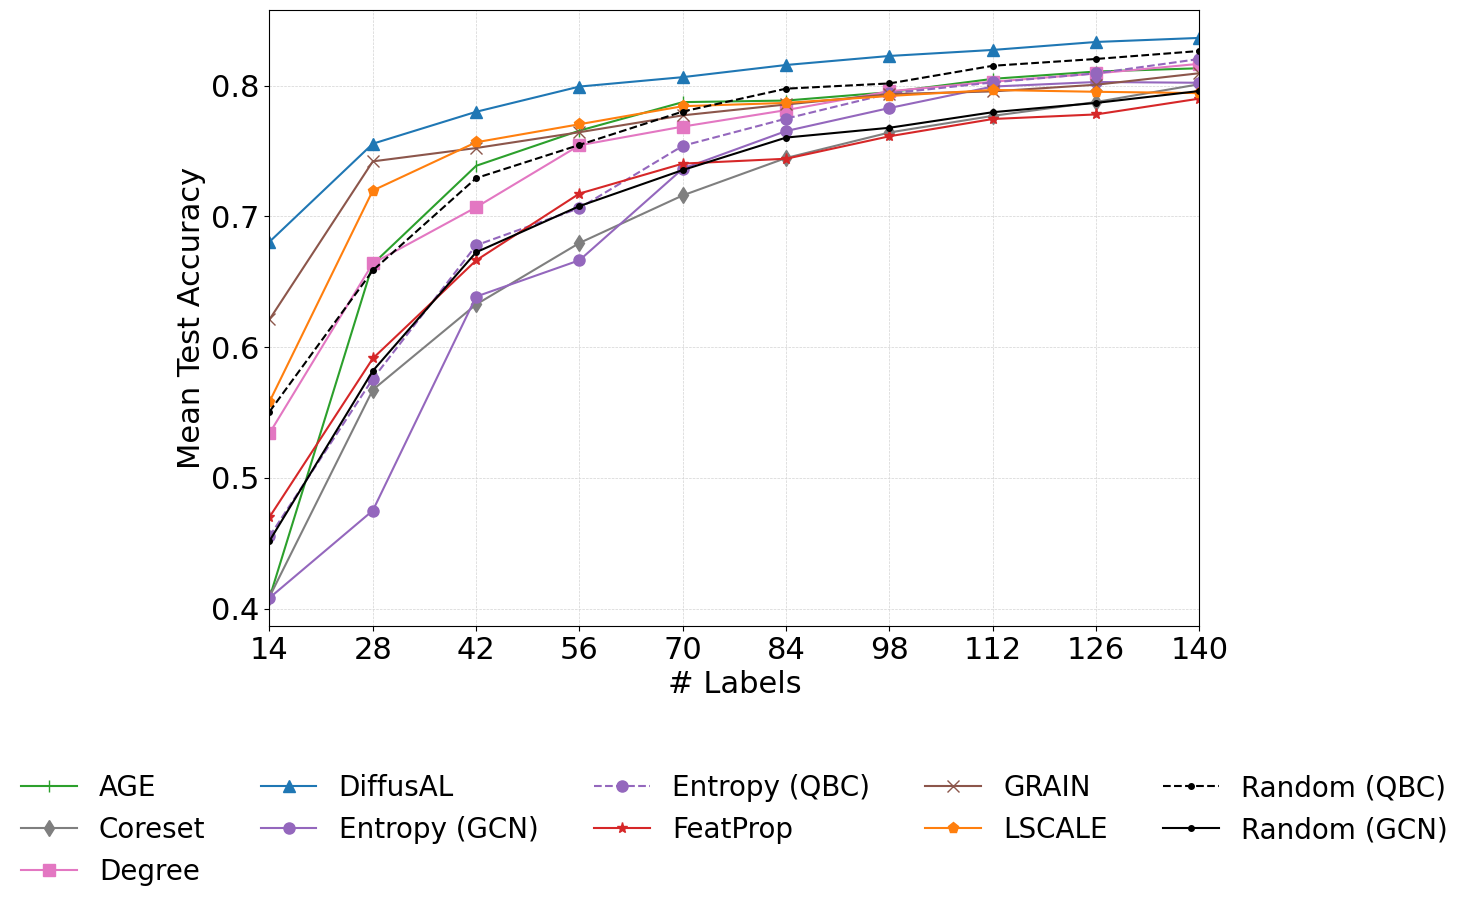

*********************************
DiffusAL_Citeseer


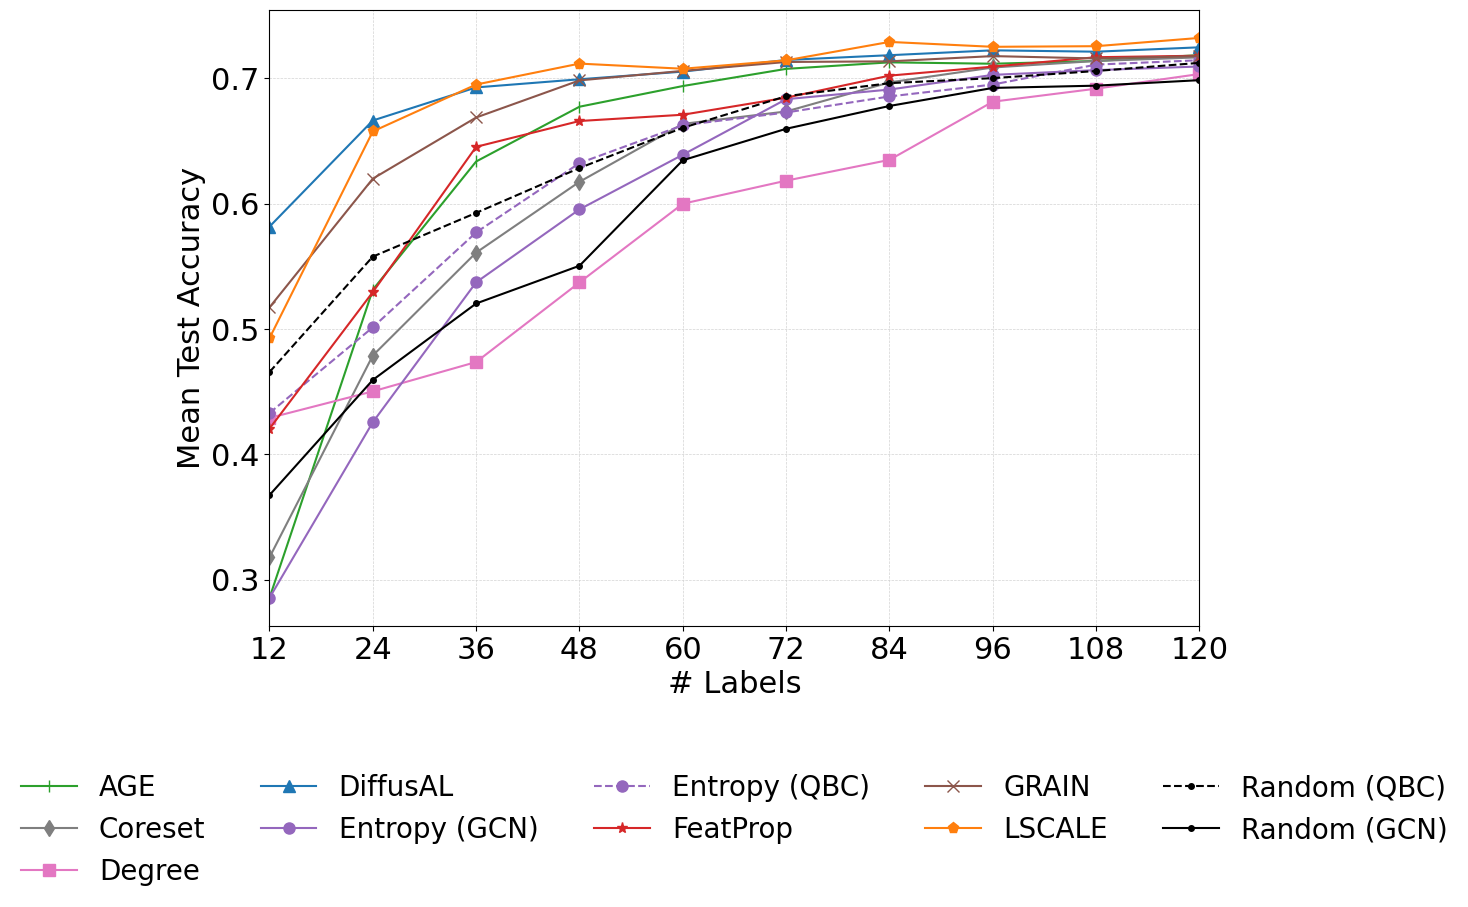

*********************************
DiffusAL_Pubmed


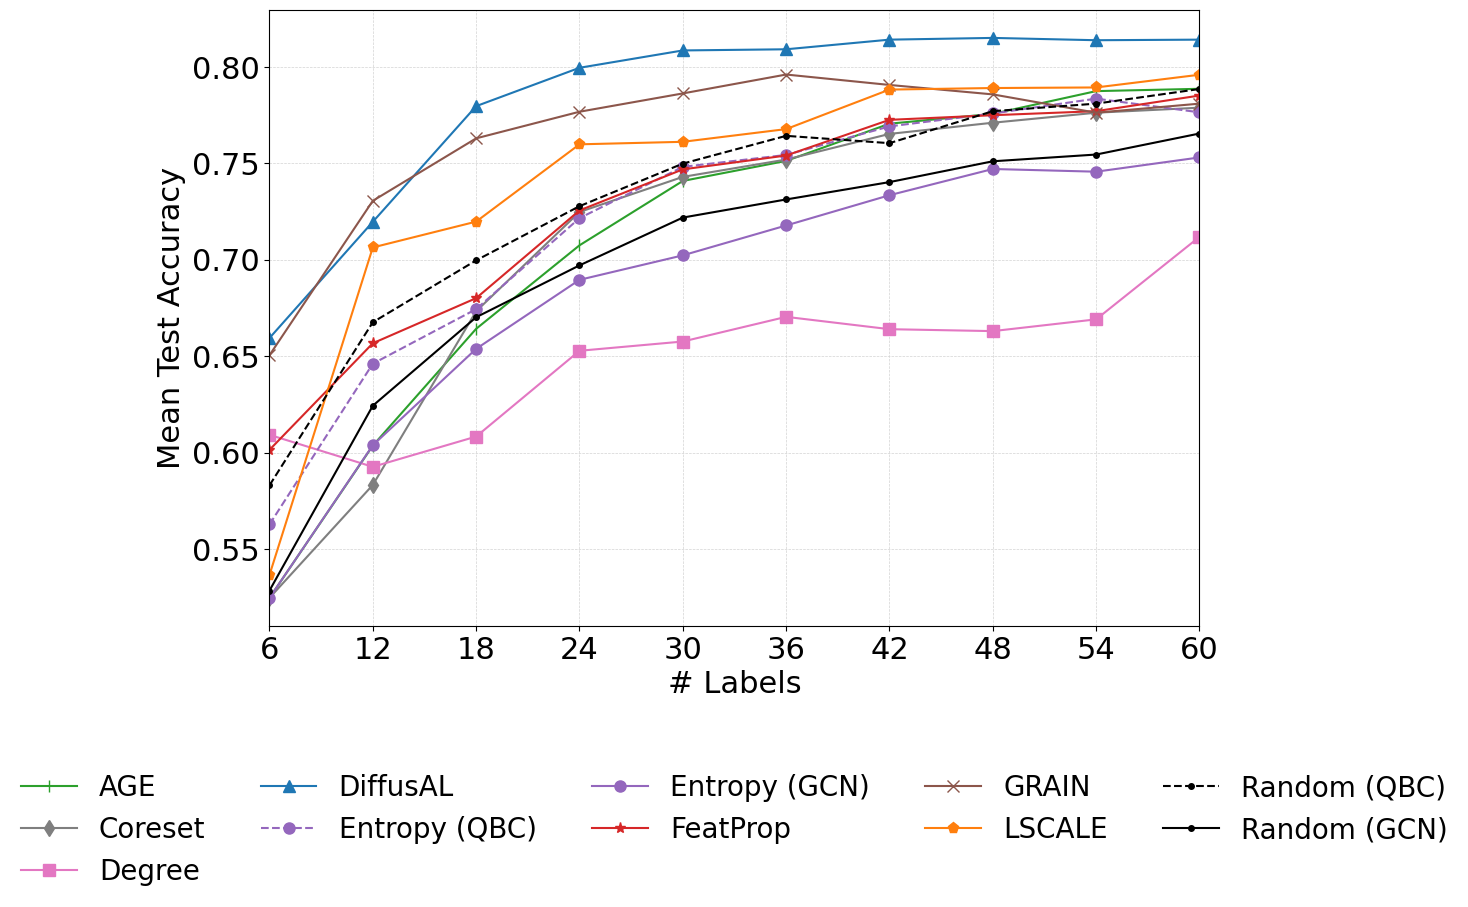

*********************************
DiffusAL_Physics


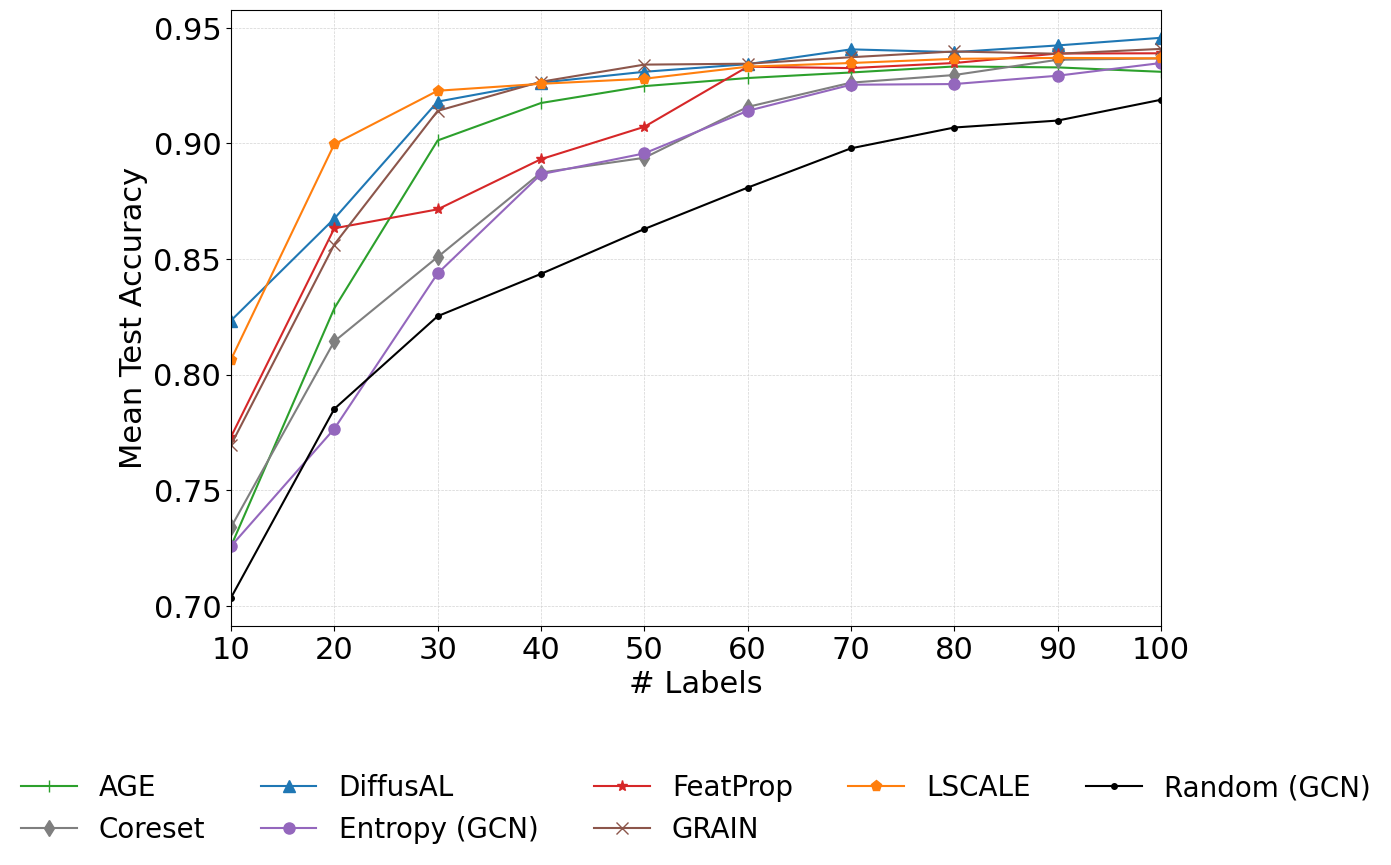

*********************************
DiffusAL_CS


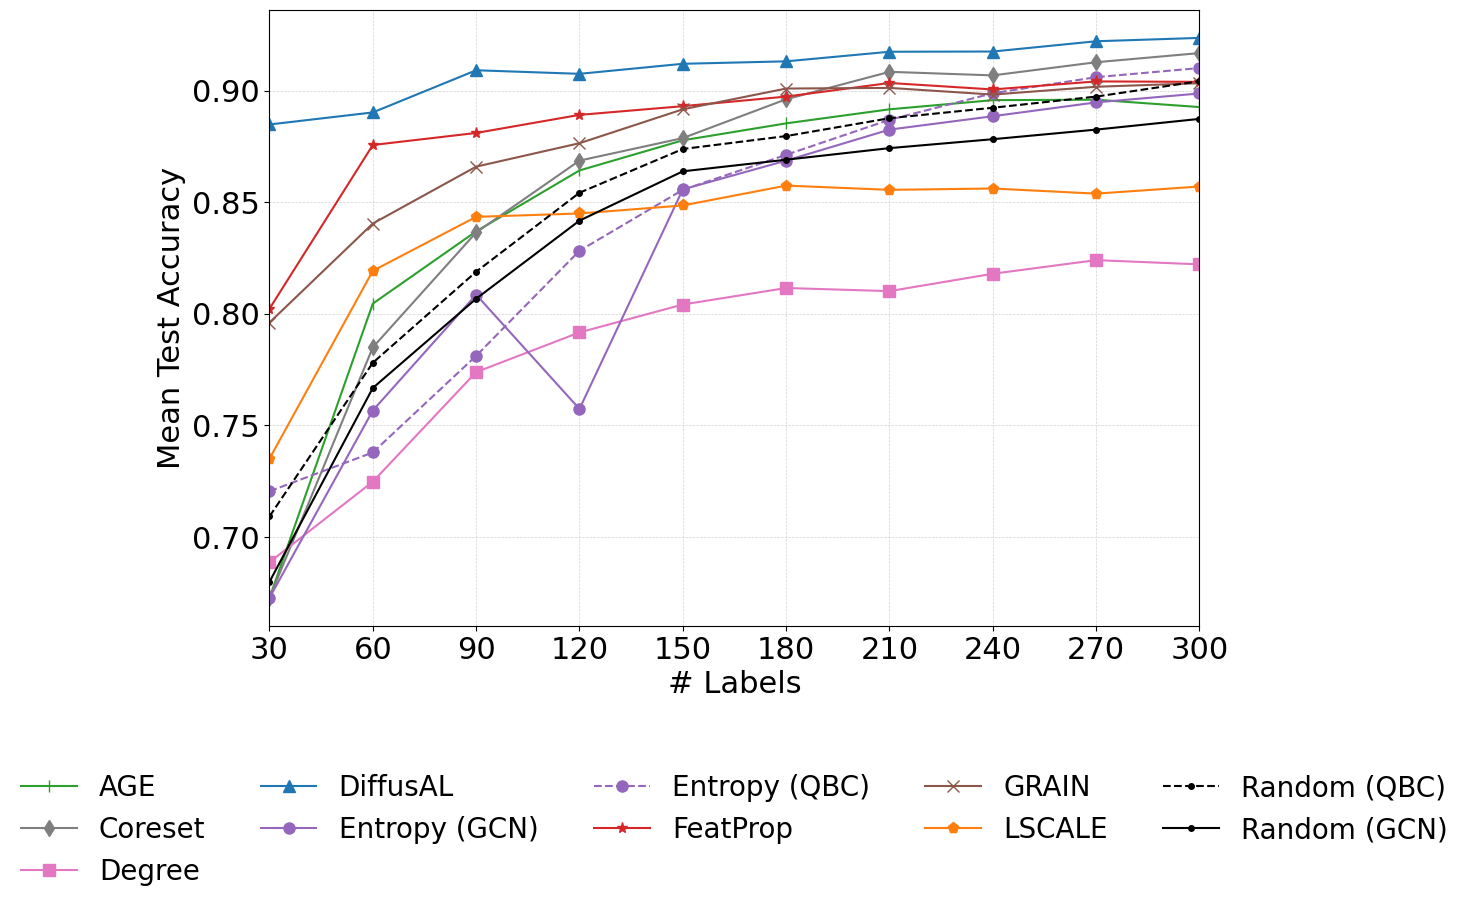

In [54]:
exps = [
    "DiffusAL_Cora",
    "DiffusAL_Citeseer", 
    "DiffusAL_Pubmed", 
    "DiffusAL_Physics",
    "DiffusAL_CS",
]

eval_metric = "mean_test_acc"
eval_std = "std_test_acc"

_display_strategies = [
    "RandomSampling", 
    "DegreeSampling",
    "EntropySampling", 
    "FeatProp",
    "GRAIN",
    "LSCALE",
    "AGE",
    "DiffusAL",
    "Coreset"
]

for exp in exps: 
    print(f"*********************************\n{exp}")
    all_runs_df = export_from_mlflow(
        mlflow_uri=mlflow_uri,
        mlflow_experiment_name=exp,
        metrics=metrics,
    )

    plt.figure(figsize=(12,8))
    
    filtered_runs_df = all_runs_df[all_runs_df.baseline.isin(_display_strategies)]
    filtered_runs_df = filtered_runs_df.sort_values(by=['baseline'])
    for run_id, row in filtered_runs_df.iterrows():
        tracking = MlflowClient()
        method = row["baseline"]
        
        avg_accs = None
        x_axis_vals = []
        if not (math.isnan(row[eval_metric])):
            avg_accs = np.array([m.value for m in tracking.get_metric_history(run_id, eval_metric)])
            x_axis_vals = np.array([m.step for m in tracking.get_metric_history(run_id, eval_metric)])
            std_test_acc = np.array([m.value for m in tracking.get_metric_history(run_id, eval_std)])
        else:
            continue 

        display_ind = 0

        label = f"{style_mapper[method][0]}"
        
        plt.plot(
            x_axis_vals[display_ind:], avg_accs[display_ind:], label=label, ms=8, 
            marker=style_mapper[method][1],
            linestyle=style_mapper[method][2],
            color = style_mapper[method][-1]
        )
        plt.xlim(x_axis_vals[display_ind],x_axis_vals[-1])
        plt.xticks(x_axis_vals[display_ind:])

    plt.xlabel('# Labels')
    plt.ylabel('Mean Test Accuracy')
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.savefig(f"img/{exp}.pdf", bbox_inches="tight")
    legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=20, ncols=5, frameon=False)
    export_legend(legend)
    plt.show()
    
